In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import mne
from tqdm import tqdm
from blab.itertools import true_meshgrid

# Load data

In [10]:
chlist = np.load('../data/TMS_MOTOR_CHANNELS.npy')
data = np.load('../data/eeg_tfr/TMS_TIME-CH-TRIAL_DAY2_IM1-2_SHAM_MOTOR-AREA_BCORR_POST.npy')
time = np.r_[1:9:0.004][1000:]

montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(chlist.tolist(), 1000, ch_types='eeg',)
info.set_montage(montage)

sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(
    info, 'eeg')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 13


In [11]:
data.shape

(1, 2, 15, 20, 1000, 13)

In [13]:
sessions = {
    'Im1': 0,
    'Im2': 1
}

subs = np.r_[:15]
# days = np.r_[:2]
sessions = np.r_[:2]
crit_muls = [0, 1, 2, 5]

index = pd.MultiIndex.from_product([sessions, subs, crit_muls])
conds = np.array(index.to_list())
results = []

for session, sub, crit_mul in tqdm(conds):
    day = 0
    a = data[day, session, sub]
    # a = np.rollaxis(a, 1)
    # a = np.rollaxis(a, 1, 3)
    a_mask = ~(np.isnan(a).any(-1).any(-1))
    a = a[a_mask]
    # print(f'{day} {session} {sub}: {np.isnan(a).any()}')
    
    alpha = 0.05/(2**int(crit_mul))
    thresh = -stats.t.ppf(q=1 - alpha, df=a.shape[0] - 1)
    
    if a.shape[0] == 0:
        res = None
    else:
        res = mne.stats.spatio_temporal_cluster_1samp_test(a, n_permutations=2000,
                                                         tail=-1, n_jobs=4, out_type='mask',
                                                         threshold=thresh,
                                                         adjacency=sensor_adjacency, stat_fun=mne.stats.ttest_1samp_no_p,
                                                         verbose=False)
    results.append(res)

# new_results = []
# for i in results:
#     if i is None:
#         new_results.append(None)
#     else:
#         T_obs, clusters, cluster_p_values, H0 = i
#         new_results.append((T_obs, cluster_p_values, H0))

npresults = np.array(results, dtype=object)
npresults = npresults.reshape(2, 15, 4, -1)
np.save('../data/TMS_TIME-CH-TRIAL_DAY2_IM1-2_SHAM_MOTOR-AREA_BCORR_POST_STAT-BY-SUB_NEG.npy', npresults)

  2%|▏         | 2/120 [00:25<23:59, 12.20s/it]/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_9862/4279788985.py:30: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  res = mne.stats.spatio_temporal_cluster_1samp_test(a, n_permutations=2000,
/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_9862/4279788985.py:30: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  res = mne.stats.spatio_temporal_cluster_1samp_test(a, n_permutations=2000,
 69%|██████▉   | 83/120 [14:26<06:21, 10.31s/it]/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_9862/4279788985.py:30: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  res = mne.stats.spatio_temporal_cluster_1samp_test(a, n_permutations=2000,
 86%|████████▌ | 103/120 [17:47<02:29,  8.77s/it]/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_9862/4279788985.py:30: RuntimeWarning: No clusters found, returning empty H0, cl

In [167]:
sas = mne.stats.spatio_temporal_cluster_1samp_test(a, n_permutations=2000,
                                                         tail=1, n_jobs=15, out_type='mask',
                                                         threshold=dict(start=0, step=0.2),
                                                         adjacency=sensor_adjacency, stat_fun=mne.stats.ttest_1samp_no_p,
                                                         verbose=False)

In [69]:
npresults = np.array(new_results, dtype=object)
npresults = npresults.reshape(2, 2, 15, -1)

In [9]:
npresults.shape

(2, 15, 4, 4)

In [70]:
np.save('../data/TMS_TIME-CH-TRIAL_DAY1-2_IM1-2_MOTOR-AREA_BCORR_POST_STAT-BY-SUB_TFCE.npy', npresults[..., 0])

In [20]:
def plot_stat_topomap(T_obs, clus, info, axes=None, cl_ind=0):
    timefreq_mask = np.any(clus, axis=-1)
    nanmask = np.zeros(clus.shape)
    nanmask[~clus] = np.nan
    T_obs_filt = T_obs + nanmask
    topo = np.nanmean((T_obs_filt).T[:,timefreq_mask], axis=-1)
    topo[np.isnan(topo)] = 0
    return mne.viz.plot_topomap(topo, info, axes=axes, show=False, names=info.ch_names, show_names=True, extrapolate='local')

def plot_topo_n_t(time, t_obs, cluster, info, time_tr_mask=None):
    if time_tr_mask is None:
        time_tr_mask = np.ones(time.shape, dtype=bool)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(time_post[time_tr_mask], np.mean(T_obs*cluster, axis=-1)[time_tr_mask])
    ax1.set_ylabel('T value')
    ax1.set_xlabel('Time (sec)')
    ax1.grid()
    im, _ = plot_stat_topomap(t_obs[time_tr_mask], cluster[time_tr_mask], info, axes=ax2)
    plt.colorbar(im, ax=ax2)
#     ax1.set_title(f'Cluster p-value = {cluster_p_values[ind]} #{ind}')
#     fig.suptitle(f'Base vs Post: Subject {sub + 1} Day {day}; {session_name} session; {band_name} band', fontsize=20)
    fig.tight_layout()
    return fig

In [39]:
print(0)

0


C:\Users\NCT\AppData\Local\Temp/ipykernel_12636/2239069646.py:11: RuntimeWarning: Mean of empty slice
  T_obs = np.nanmean(T_obs, -1)


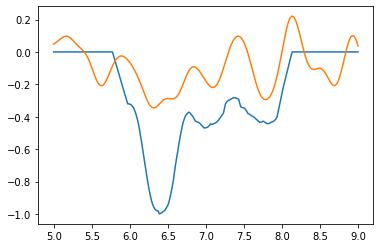

In [158]:
day = 1
sess = 1
sub = 4
test = npresults[day, sess, sub, 0]
T_obs, cluster_p_values, _ = test
cluster_p_values = cluster_p_values.reshape(1000, 13)
p_mask = cluster_p_values > 0.1
# cluster_p_values = cluster_p_values*np.sign(T_obs)
T_obs = -np.log10(cluster_p_values)*T_obs
T_obs[p_mask] = np.nan
T_obs = np.nanmean(T_obs, -1)
T_obs[np.isnan(T_obs)] = 0
f = 50
T_obs = np.convolve(T_obs, np.ones(f), mode='same')/f

chmask = (~p_mask).any(0)
a = data[day, sess, chmask, sub].mean(0)
a = np.nanmean(a, 0)
mm = np.max(np.abs(T_obs))
plt.plot(time, T_obs/mm)
plt.plot(time, a)